# Functional HSIC

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import math
import pandas as pd
from scipy.stats import gamma
from scipy.interpolate import UnivariateSpline
import random

Different combinations of $(X, Y)$ to evaluate the approximation methods.

## Examples of one to three-dimensional distributions

In [2]:
#X = np.random.normal(0, 1, 256).reshape(-1,1)
#X = np.random.exponential(size=100).reshape(-1,1)
#X = np.random.chisquare(1, size=20).reshape(-1,1)
X = np.random.multivariate_normal([0,1,2], [[1,1,1], [1,1,1], [1,1,1]], size=512)
#X = np.random.randn(20*128).reshape(20,-1)


#Y = np.random.normal(0, 1, 64).reshape(-1,1)
#Y = np.random.exponential(size=256).reshape(-1,1)
#Y = np.random.randn(20*128).reshape(20,-1)
Y = np.random.multivariate_normal([10,11,12], [[11,11,11], [11,11,11], [11,11,11]], size=512)

In [3]:
print(X.shape)
print(Y.shape)

(512, 3)
(512, 3)


## Examples of higher-dimensional distributions

Same for non-stationary processes:

In [252]:
# dimensions
as_is = 12
to_be = 100

# how many samples
samples = 512

# set how far to shift Y (+ shifts to the left, - shifts to the right)
shift_p = 1   # in as_is resolution
shift_par = int(shift_p * to_be / as_is)

print('Shifting for:', shift_par)

# creating dependence
power = 2
mult = 3
add = np.random.normal(0, 1)

Shifting for: 8


[ 0.69755698  0.28108346  0.43674363  0.00993441  1.78462446  1.18995024
  0.2273485   0.21759933  1.01956314  0.05331502 -0.67263434 -1.36937916]


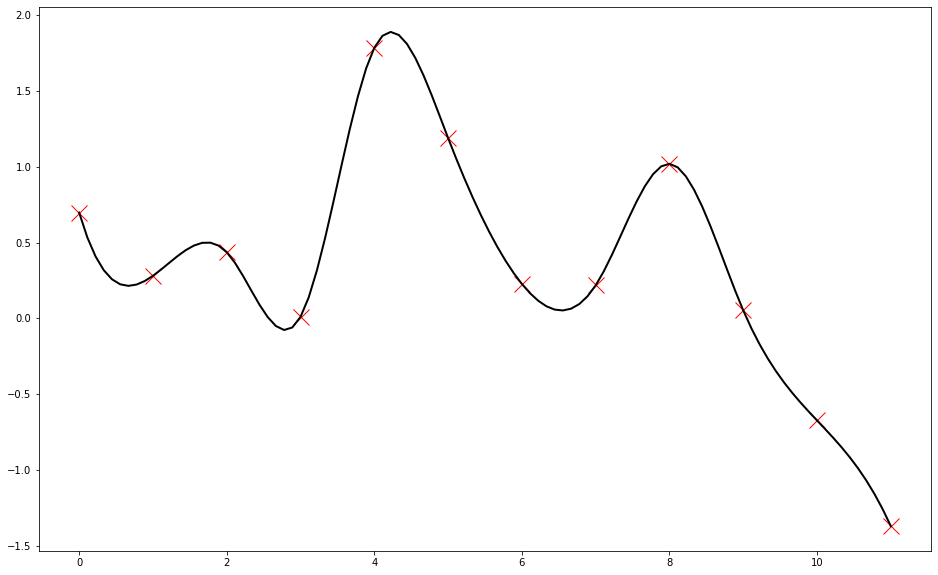

In [253]:
x1 = np.linspace(0, as_is-1, as_is)
time1 = np.random.uniform(-2, 2, as_is)
print(time1)
plt.figure(figsize=(16,10))
plt.plot(time1, 'xr', markersize=16);

# fitting spline to data
spl1 = UnivariateSpline(x1, time1, k=3, s=0)
xs1 = np.linspace(0, as_is-1, to_be)
plt.plot(xs1, spl1(xs1), color='black', linewidth=2);
plt.show()

[-0.54323244  0.31575952 -1.60242334 -1.1630749   1.1418497  -1.73315866
 -0.14673427 -1.84855557  0.63312912 -1.46129373  1.31808082 -1.19448809]


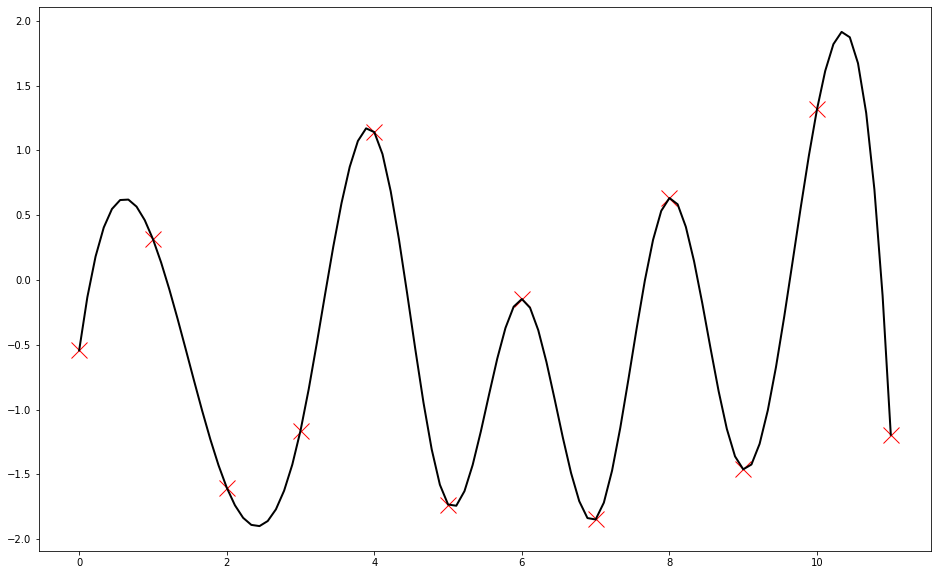

In [254]:
# different and independent
x2 = np.linspace(0, as_is-1, as_is)
time2 = np.random.uniform(-2, 2, as_is)
print(time2)
plt.figure(figsize=(16,10))
plt.plot(time2, 'xr', markersize=16);

# fitting spline to data
spl2 = UnivariateSpline(x2, time2, k=3, s=0)
xs2 = np.linspace(0, as_is-1, to_be)
plt.plot(xs2, spl2(xs2), color='black', linewidth=2);
plt.show()

# Generating high-dimensional distributions satisfying either $H_0: P_{XY} = P_X P_Y$ or $H_1: P_{XY} \neq P_X P_Y$ of HSIC

In [255]:
# generic function to generate different kinds of dependencies
def dependence(X, power=1, mult=1, add=0):
    return np.multiply(np.power(X, power), mult) + add

In [256]:
# generating distributions over time

t1d = np.empty((0, samples))
t2d = np.empty((0, samples))

for t in spl1(xs1):
    var = np.random.uniform(0,1,1)
    dist1 = np.random.normal(t, var, samples)
    t1d = np.append(t1d, [dist1], axis=0)

# H0: P_{XY} = P_X P_Y: independent
#for t in spl2(xs2):
#    var = np.random.uniform(0,1,1)
#    dist2 = np.random.normal(t, var, samples)
#    t2d = np.append(t2d, [dist2], axis=0)

# H1: P_{XY} != P_X P_Y: dependent
t2d = dependence(t1d, power=power, mult=mult, add=add)

# shifting time2
if shift_par >= 0:
    t2d = t2d[shift_par:]
elif shift_par < 0:
    t2d = t2d[:shift_par]

time1d = t1d.T
time2d = t2d.T

### Plottings

(512, 100)


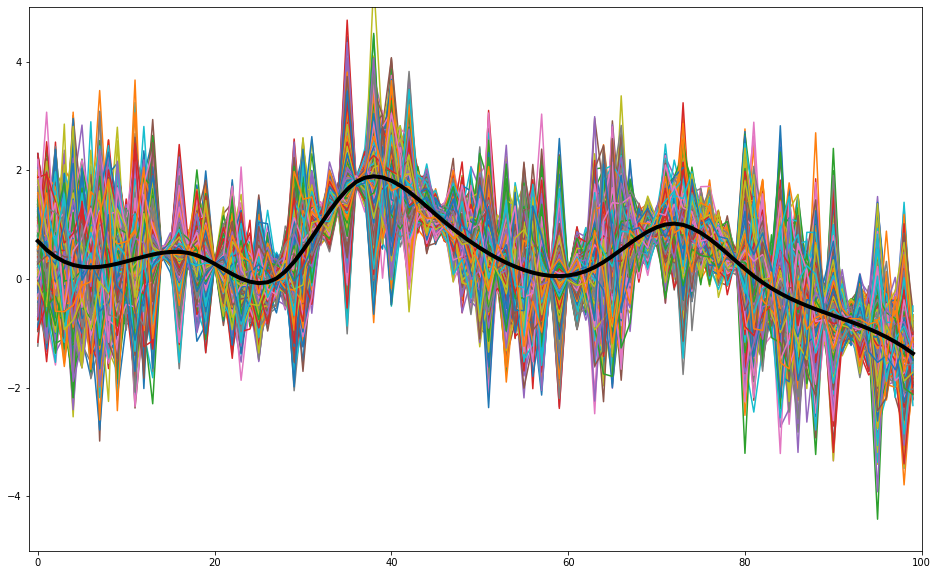

In [257]:
# different dimensions
print(time1d.shape)
plt.figure(figsize=(16,10))
plt.axis([-1, time1d.shape[1], -5, 5])
plt.plot(time1d.T);
plt.plot(spl1(xs1), color='black', linewidth=4);
plt.show()

(512, 92)


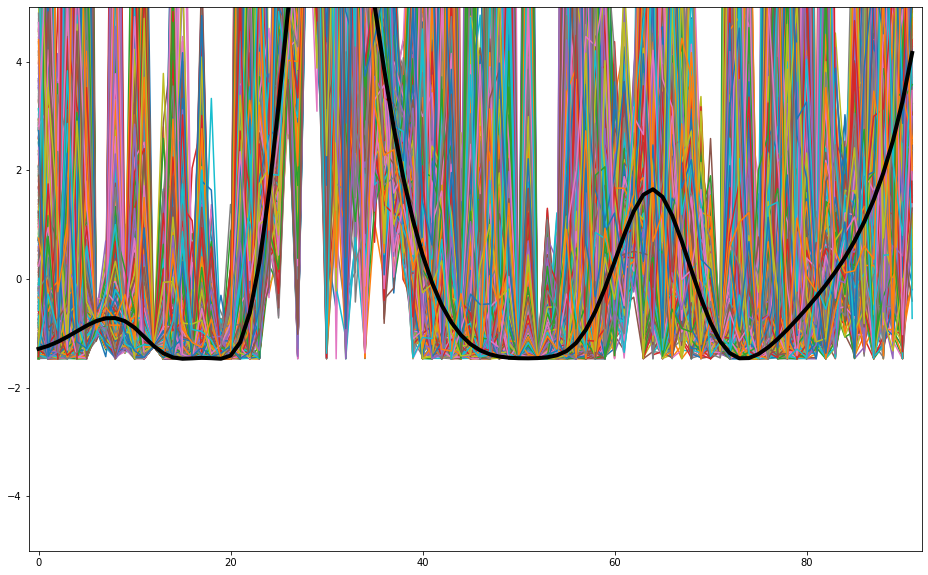

In [258]:
print(time2d.shape)
plt.figure(figsize=(16,10))
plt.axis([-1, time2d.shape[1], -5, 5])
plt.plot(time2d.T);
plt.plot(dependence(spl1(xs1)[shift_par:], power=power, mult=mult, add=add), color='black', linewidth=4);    # change according to dependence
plt.show()

In [259]:
# same dimensions
if shift_par > 0:
    X = time1d[:, :-shift_par]
    Y = time2d
elif shift_par < 0:
    X = time1d[:, -shift_par:]
    Y = time2d
else:
    X = time1d
    Y = time2d

(512, 92)


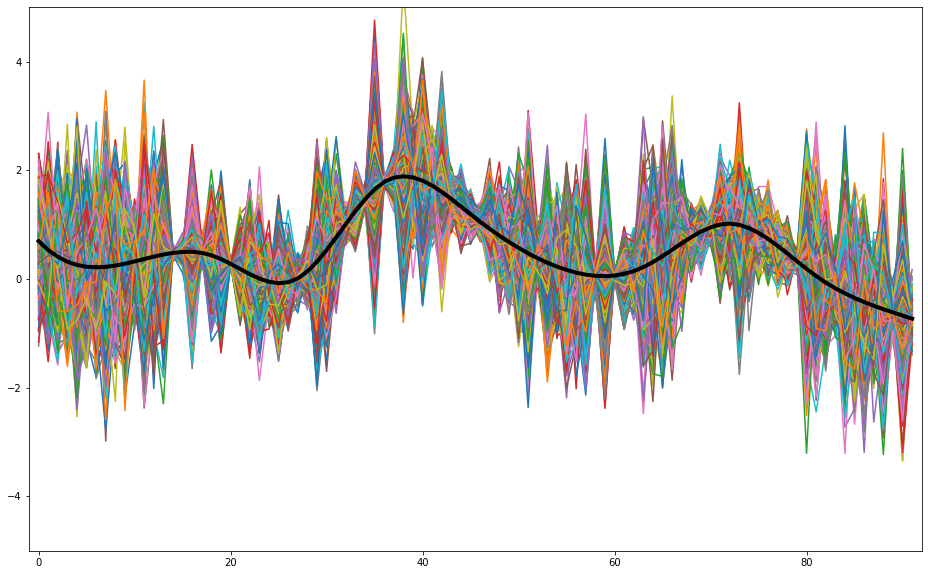

In [260]:
print(X.shape)
plt.figure(figsize=(16,10))
plt.axis([-1, X.shape[1], -5, 5])
plt.plot(X.T);
if shift_par > 0:
    plt.plot(spl1(xs1)[:-shift_par], color='black', linewidth=4);
elif shift_par < 0:
    plt.plot(spl1(xs1)[-shift_par:], color='black', linewidth=4);
else:
    plt.plot(spl1(xs1), color='black', linewidth=4);
plt.show()

(512, 92)


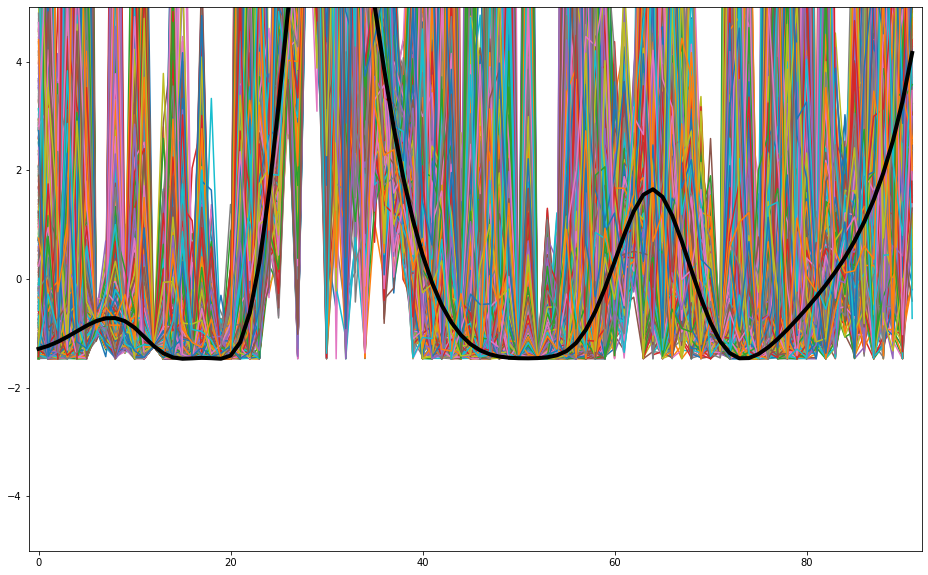

In [261]:
print(Y.shape)
plt.figure(figsize=(16,10))
plt.axis([-1, Y.shape[1], -5, 5])
plt.plot(Y.T);
plt.plot(dependence(spl1(xs1)[shift_par:], power=power, mult=mult, add=add), color='black', linewidth=4);
plt.show()

Show their dependence:

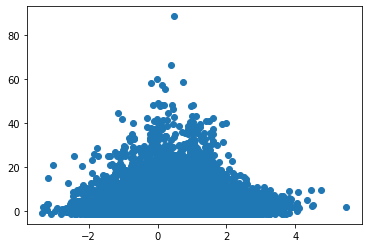

In [262]:
plt.scatter(X, Y);

### Auxiliary functions

In [263]:
# median heuristic for kernel width
def width(Z):
    # compute median for Z
    size_Z = Z.shape[0]
    if size_Z > 100:
        Z_med = Z[0:100]
        size_Z = 100
    else:
        Z_med = Z

    G_Z = np.sum(np.multiply(Z_med, Z_med), axis=1).reshape(-1,1)
    Q_Z = np.tile(G_Z, (1, size_Z))
    R_Z = np.tile(G_Z.T, (size_Z, 1))
    dists_Z = Q_Z + R_Z - 2 * Z_med @ Z_med.T
    distances_Z = (dists_Z - np.tril(dists_Z)).reshape(-1, 1)
    width_Z = np.sqrt(0.5*np.median(distances_Z[distances_Z>0]))
    d_Z = Z.shape[1]
    
    return d_Z * width_Z


# rbf dot product
def rbf_dot(X, Y, width):
    size_X = X.shape
    size_Y = Y.shape
    
    G = np.sum(np.multiply(X, X), axis=1).reshape(-1,1)
    H = np.sum(np.multiply(Y, Y), axis=1).reshape(-1,1)
    
    Q = np.tile(G, (1, size_Y[0]))
    R = np.tile(H.T, (size_X[0], 1))
    
    H = Q + R - 2 * X @ Y.T
    
    # rbf kernel
    K = np.exp(-H/(2*width**2))
    
    return K

# HSIC

$\mathcal{H}_0: P_{XY} = P_X P_Y$ is a complex distribution and must be approximated. Here, we approximate it first by randomly permuting the order of $Y$ whilst the order of $X$ is kept fixed, and second by a Gamma distribution with parameters $\alpha$ (`al`) and $\beta$ (`bet`).

## HSIC with permutations

In [264]:
def HSIC_permutations(X, Y, alpha, width_X, width_Y, shuffle):    # set widths to -1 for median heuristics
    
    m = X.shape[0]
    
    # median heuristics for kernel width
    if width_X == -1:
        width_X = width(X)      
    if width_Y == -1:
        width_Y = width(Y)
    
    # compute Gram matrices
    K = rbf_dot(X, X, width_X)
    L = rbf_dot(Y, Y, width_Y)
    
    # centering matrix...
    H = np.eye(m) - (1/m) * (np.ones((m, m)))
    
    # ...to center K
    K_c = H @ K @ H
    
    # test statistic
    stat = 1/(m**2) * np.sum(np.multiply(K_c.T, L))
    
    # initiating HSIC
    HSIC_arr = np.zeros(shuffle)
    
    # create permutations by reshuffling L except the main diagonal
    for sh in range(shuffle):
        n = ~np.eye(len(L), dtype=bool)
        Ln = L[n]
        np.random.shuffle(Ln)
        L[n] = Ln
        HSIC_arr[sh] = 1/(m**2) * np.sum(np.multiply(K_c.T, L))
        
    HSIC_arr_sort = np.sort(HSIC_arr)
    
    # computing 1-alpha threshold
    threshold = HSIC_arr_sort[round((1-alpha)*shuffle)]
    
    if stat > threshold:
        print('H0 rejected')
    else:
        print('H0 accepted')
    
    return (stat, threshold)

## HSIC with Gamma distribution approximation

In [265]:
def HSIC_gamma(X, Y, alpha, width_X, width_Y):    # set widths to -1 for median heuristics
    
    m = X.shape[0]
    
    # median heuristics for kernel width
    if width_X == -1:
        width_X = width(X)      
    if width_Y == -1:
        width_Y = width(Y)
    
    # compute Gram matrices
    K = rbf_dot(X, X, width_X)
    L = rbf_dot(Y, Y, width_Y)
    
    # centering matrix...
    H = np.eye(m) - (1/m) * (np.ones((m, m)))
    
    # ...to center K and L
    K_c = H @ K @ H
    L_c = H @ L @ H
    
    # test statistic
    stat = 1/m * np.sum(np.multiply(K_c.T, L))
    
    # fitting Gamma distribution to stat
    vHSIC = np.power(1/6 * np.multiply(K_c, L_c), 2)
    vaHSIC = 1/(m*(m-1)) * (np.sum(vHSIC) - np.trace(vHSIC))
    varHSIC = 72*(m-4)*(m-5)/(m*(m-1)*(m-2)*(m-3)) * vaHSIC    # variance under H0
        
    K_diag = K - np.diag(np.diag(K))
    L_diag = L - np.diag(np.diag(L))
    
    bone = np.ones(m)
    
    mu_X = 1/(m*(m-1)) * bone @ (K @ bone)
    mu_Y = 1/(m*(m-1)) * bone @ (L @ bone)
    
    mHSIC = 1/m * (1 + mu_X * mu_Y - mu_X - mu_Y)    # mean under H0
    
    al = mHSIC**2 / varHSIC
    bet = varHSIC * m / mHSIC
    
    # computing 1-alpha threshold
    threshold = gamma.ppf(1-alpha, al, scale=bet)
    
    if stat > threshold:
        print('H0 rejected')
    else:
        print('H0 accepted')
    
    return (stat, threshold)

### Evaluations

In [266]:
# test level alpha = 0.05, 5000 permutations
HSIC_permutations(X, Y, 0.05, -1, -1, 5000)

H0 rejected


(2.2288260111921814e-10, 3.7186405522343976e-11)

In [267]:
# test level alpha = 0.05
HSIC_gamma(X, Y, 0.05, -1, -1)

H0 accepted


(1.1411589177303969e-07, 3.3329568239512674e-06)